## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [7]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

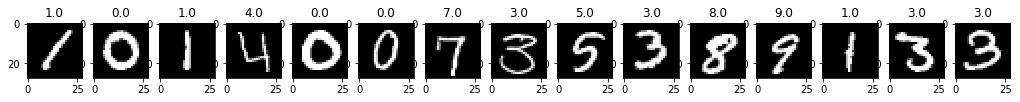

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:15], 1):
    subplot = fig.add_subplot(1, 17, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [7]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [9]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

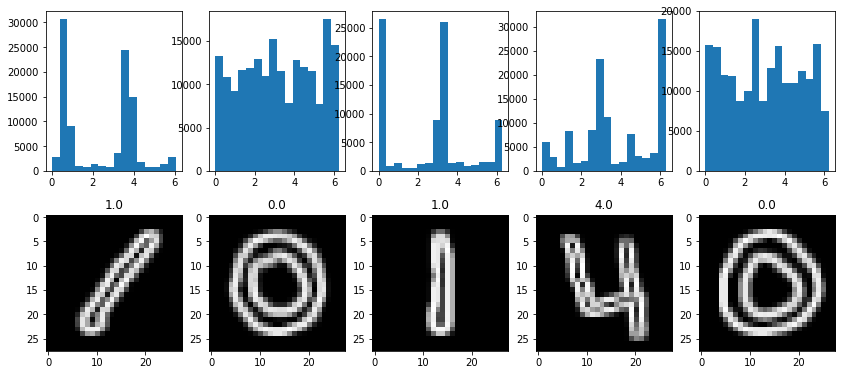

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [11]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [12]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [13]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [14]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [15]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [16]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [17]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Находим ближайший центройд для валидации

In [18]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## Оцениваем качество решение на валидационной выборке

In [19]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.4270238095238095


In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.34      0.12      0.18       816
        1.0       0.59      0.76      0.66       909
        2.0       0.33      0.29      0.31       846
        3.0       0.55      0.49      0.51       937
        4.0       0.33      0.31      0.32       839
        5.0       0.46      0.67      0.55       702
        6.0       0.24      0.45      0.31       785
        7.0       0.73      0.41      0.53       893
        8.0       0.39      0.49      0.44       835
        9.0       0.48      0.27      0.34       838

avg / total       0.45      0.43      0.42      8400



In [21]:
from sklearn.metrics import confusion_matrix #по строкам матрица попаданий смотрим на большие числа
print(confusion_matrix(y_val, pred_val))

[[102  24  82  30 106  18 221   7 179  47]
 [  0 692   2   0  44   1 139  17  13   1]
 [ 21   0 245 158  12 203  54  16 119  18]
 [ 14   0 113 456   3 235   7   2  98   9]
 [ 11 248   5   2 260   0 205  43  37  28]
 [  3   0  84  97   5 472   3   4  33   1]
 [ 53  26  66  11 116   4 355  13  76  65]
 [  4 113  38  16  66  41 189 368  15  43]
 [ 81   6  68  44  36  44 107   3 411  35]
 [ 11  73  31  20 149  11 222  30  65 226]]


## Предсказания на тестовыйх данных

In [22]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

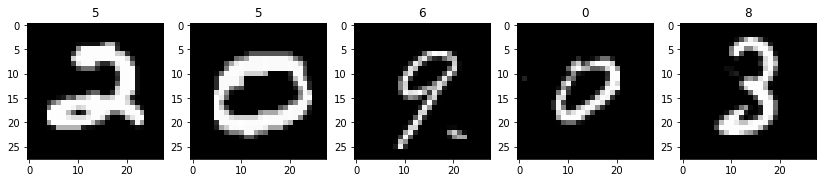

In [23]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [24]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
#score 0.42071

## PCA

In [3]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(train[:, 1:])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

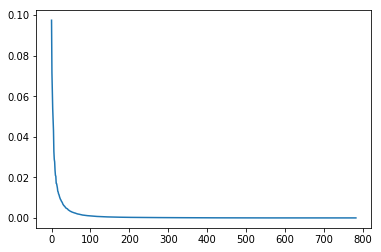

In [4]:
plt.plot(pca.explained_variance_ratio_)
plt.show()

In [5]:
pca = PCA(n_components=100)
pca.fit(train[:, 1:])
print(pca.explained_variance_ratio_)

[0.09748938 0.07160266 0.06145903 0.05379302 0.04894262 0.04303214
 0.03277051 0.02892103 0.02766902 0.02348871 0.02099325 0.02059001
 0.01702553 0.01692787 0.01581126 0.0148324  0.01319688 0.01282727
 0.01187976 0.01152755 0.01072191 0.01015199 0.00964902 0.00912846
 0.00887641 0.00838766 0.00811856 0.00777406 0.00740635 0.00686661
 0.00657982 0.00638799 0.00599367 0.00588913 0.00564335 0.00540967
 0.00509222 0.00487505 0.00475569 0.00466545 0.00452952 0.00444989
 0.00418255 0.00397506 0.00384542 0.00374919 0.00361013 0.00348522
 0.00336484 0.00320736 0.00315467 0.00309142 0.00293707 0.0028654
 0.00280755 0.00269616 0.00265823 0.00256283 0.00253816 0.00246172
 0.00239699 0.00238733 0.00227566 0.00221493 0.00213915 0.00206081
 0.00202828 0.00195924 0.0019356  0.0018843  0.00186638 0.00181578
 0.00176785 0.00172428 0.00165983 0.00163261 0.00160403 0.00154149
 0.00146629 0.0014192  0.00140632 0.00139835 0.00137881 0.00133848
 0.00131045 0.00130199 0.00128359 0.00122825 0.00121177 0.00117

In [13]:
from sklearn.ensemble import RandomForestClassifier
X_pca = np.dot(train[:, 1:], pca.components_.T)
model = RandomForestClassifier(max_depth=15, random_state=100)
model.fit(X_pca, train_label)
X_test = np.dot(test, pca.components_.T)
predicted = model.predict(X_test)

In [14]:
with open('submit_pca_rf.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(predicted, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [ ]:
#score 0.9...